In [71]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%load_ext autoreload
%autoreload 2

import tensorflow as tf
import keras
# import gensim
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import os
from os import listdir
from os.path import isfile, join
import random
import shutil
import pandas as pd
from collections import defaultdict
import re
import gensim
from bs4 import BeautifulSoup

import sys
from scipy import sparse

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import time

from attention import * 
from tensorflow.python.ops.rnn import bidirectional_dynamic_rnn as bi_rnn
from tensorflow.contrib.rnn import GRUCell


import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
MAX_SENT_LENGTH = 100
MAX_SENTS = 100 # this is the longest number of sentences in a document!!!
MAX_NB_WORDS = 60000
EMBEDDING_DIM = 300 #due to word2vec dimension!!! 
HIDDEN_SIZE = 50 #based on Yang et al CMU. (Hierachical Attention Networks for Document Classification)
ATTENTION_SIZE = 100 #same as Yang et al. 
BATCH_SIZE = 50
NUM_ITERS = 100
DISPLAY_STEP = 10
VALIDATION_STEP = 10
TESTING_BATCH = 10
USER_EMBEDDING_DIM = 200

In [73]:
tic = time.time()
# Download GoogleNews-vectors-negative300.bin.gz at 
#https://github.com/mmihaltz/word2vec-GoogleNews-vectors/blob/master/GoogleNews-vectors-negative300.bin.gz
word2vec = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
toc = time.time()
print("Running time of loading Word2Vec model: ", (toc - tic))

Running time of loading Word2Vec model:  101.50209975242615


In [74]:
def batch_generator(X, y, batch_size):
    """Primitive batch generator 
    """
    size = X.shape[0]
    X_copy = X.copy()
    y_copy = y.copy()
    indices = np.arange(size)
    np.random.shuffle(indices)
    X_copy = X_copy[indices]
    y_copy = y_copy[indices]
    i=0

    while True:
        left, right = i*batch_size, (i+1)*batch_size
        right = min(size, right)
        yield X_copy[left:right], y_copy[left:right]
        if right >= size:
            i = 0
            indices = np.arange(size)
            X_copy = X_copy[indices]
            y_copy = y_copy[indices]
        else:
            i+=1

In [75]:
def fit_tokenizer_based_on_training(train_folder, test_folder, dict_selected_words,
                                   ground_truth_file='snopes_ground_truth.csv'):
    '''Return tensor data of URL based solely on training interactions only!!!'''
    
    
    df = pd.read_csv(ground_truth_file)
    full = zip(df['snopes_page'], df['claim_label'])
    dict_url_ground_truth = {}
    for url, label in full:
        assert label == True or label == False
        if label == True:
            dict_url_ground_truth[url] = 1
        elif label == False:
            dict_url_ground_truth[url] = 0
        
    assert len(dict_url_ground_truth) == 562
    
    def read_text_files(infolder):
        documents = [fn for fn in listdir(infolder) if fn.endswith('.txt')]
        data = np.zeros((len(documents), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
        dict_docs = {}
        for fn in documents:
            p = join(infolder, fn)
            fin1 = open(p, 'r')
            url = fin1.readline().replace('\n', '')
            assert 'http' in url
            sents = []
            for line in fin1:
                sents.append(line.replace('\n', ''))
            dict_docs[url] = sents
                
        Y = []
        for idx, url in enumerate(dict_docs.keys()):
            assert 'http' in url
            label = dict_url_ground_truth[url]
            assert label == 0 or label == 1
            Y.append([label, 1-label])
            sentences = dict_docs[url]
            for j, sent in enumerate(sentences):
                if j < MAX_SENTS:
                    wordTokens = text_to_word_sequence(sent)
                    k = 0
                    for _, word in enumerate(wordTokens):
                        if word not in dict_selected_words:
                            continue
                        index_of_word = dict_selected_words[word]
                        assert index_of_word >= 1 and index_of_word <= 16000
                        if k < MAX_SENT_LENGTH:
                            data[idx, j, k] = index_of_word
                            k+=1
                    
        return data, np.array(Y)
        
    X_train, y_train = read_text_files(infolder=train_folder)
    X_test, y_test = read_text_files(infolder=test_folder)
    print(y_train.shape, "here")
    return X_train, y_train, X_test, y_test

In [76]:
def load_url_content_text2num(selected_words_file='out_top_16K_words_file.txt'):
    parent = "train_test_data"
    dict_folds = {}
    fin = open(selected_words_file, 'r')
    cnt = 1
    dict_selected_words = {}
    for line in fin:
        _, w, _ = line.split()
        dict_selected_words[w] = cnt
        cnt += 1
    assert len(dict_selected_words) == 16000 and max(dict_selected_words.values()) == 16000
    fin.close()
    
    for i in range(0, 5):
        #########################################################
        dict_words = {} #for stat
        data_i = '%s/data_%s' % (parent, i)
        train_folder = '%s/train' % data_i
        test_folder = '%s/test' % data_i
        X_train, y_train, X_test, y_test = fit_tokenizer_based_on_training(train_folder, test_folder, dict_selected_words)
        dict_folds[i] = (X_train, y_train, X_test, y_test)
        
    return dict_folds, dict_selected_words

In [77]:
dict_folds, dict_selected_words = load_url_content_text2num()

(448, 2) here
(448, 2) here
(448, 2) here
(448, 2) here
(448, 2) here


In [78]:
no_vocabs = 16000 
'''Word2vec embedding matrix'''
embedding_matrix = np.random.random((no_vocabs, EMBEDDING_DIM))
#i starts at 1 not 0 like normal stuff!!!!
for word, i in dict_selected_words.items(): 
    if word in word2vec.wv.vocab:
        embedding_vector = word2vec[word]
        embedding_matrix[i-1] = embedding_vector

In [79]:
def computeMetrics(true_labels, pred_labels):
    assert y_true.shape == y_hat.shape
    # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
    TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))  
    # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
    TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))  
    # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
    FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))  
    # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
    FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))  
    #print 'TP: %i, FP: %i, TN: %i, FN: %i' % (TP,FP,TN,FN)
    assert TP+ TN+ FP+ FN == len(true_labels)
    return TP, TN, FP, FN


In [80]:
y_true = np.array([0,0, 1, 1, 1, 0, 0, 0, 1, 0]) 
y_hat = np.array([0, 0, 1, 1, 0, 1, 0, 0, 1, 0])
print(computeMetrics(y_true, y_hat))

(3, 5, 1, 1)


In [81]:
def hamBiRNN(X_train, y_train, X_test, y_test, log_dir, outfile):
        tf.reset_default_graph() 
        train_batch_generator = batch_generator(X_train, y_train, BATCH_SIZE)
        fout = open(outfile, 'w')
        '''Variable with shape (no_vocabs, EMBEDDING_DIM) to get vectors in a sentence'''
        embedding_matrix_variable = tf.Variable(embedding_matrix, trainable=True, dtype=tf.float32)
        #print(embedding_matrix_variable.shape)
        #print(X_train.shape)

        '''We will take a bunch of sentences, where each sentence has length MAX_SENT_LENGTH
        Ex: Two sentences: [[1,2,5,6,0], [3,5,3,6,0]] where numbers indicate a word. We will look up the 
        word vector for each word based on the number. 
        '''
        #batch_sent_ph = tf.placeholder(tf.int32, [None, MAX_SENT_LENGTH]) 
        '''
        Hope it work. After looking up, the shape should be 
        (batch_size, MAX_SENTS, MAX_SENT_LENGTH, EMBEDDING_DIM)
        However, since we need to use bi_rnn and we learn representation of sentences first. 
        Therefore, we should use shape 
        (?, MAX_SENT_LENGTH, EMBEDDING_DIM) where "?" should be a multiple of MAX_SENTS
        '''
        batch_sent_ph = tf.placeholder(tf.int32, [None, MAX_SENT_LENGTH], name="batch_sent_ph")
        batch_sent_embedded = tf.nn.embedding_lookup(embedding_matrix_variable, batch_sent_ph)
        y_ph = tf.placeholder(tf.float32, [None, 2], name="labels")
        sentence_length_ph = tf.placeholder(tf.int32, [None], name="sentence_length_ph")
        doc_actual_length_ph = tf.placeholder(tf.int32, [None], name="doc_actual_length_ph")
        #print(batch_sent_embedded)

        '''We do not specify sequence_length. 
        Therefore, the number of GRU cell in forward (same as backward) is MAX_SENT_LENGTH'''
        with tf.variable_scope("first_bi_rnn"):
            rnn_outputs, _ = bi_rnn(GRUCell(HIDDEN_SIZE), GRUCell(HIDDEN_SIZE), 
                                    inputs=batch_sent_embedded, 
                                    sequence_length=sentence_length_ph, 
                                    dtype=tf.float32)
        with tf.name_scope("attention_first_bi_rnn"):
            attention_output, alphas = attention(rnn_outputs, ATTENTION_SIZE, return_alphas=True)
        with tf.name_scope("dropout_afterfirst_bi_rnn"):
            dropout_first_bi_rnn = tf.nn.dropout(attention_output, keep_prob=0.8)
        with tf.name_scope("sent_bedding_after_first_birnn"):
            sent_bedding_after_first_birnn = tf.reshape(dropout_first_bi_rnn, shape=[-1, MAX_SENTS, 2*HIDDEN_SIZE])
        ###########second bi-rnn-layer ############################
        with tf.variable_scope("second_bi_rnn"):
            bi_rnn_sent_outputs, _ = bi_rnn(GRUCell(2*HIDDEN_SIZE), GRUCell(2*HIDDEN_SIZE), 
                                            inputs=sent_bedding_after_first_birnn, 
                                            sequence_length=doc_actual_length_ph,
                                            dtype=tf.float32)
        with tf.name_scope("attention_second_bi_rnn"):
            attention_output2, alphas = attention(bi_rnn_sent_outputs, ATTENTION_SIZE, return_alphas=True)
        with tf.name_scope("dropout_after_second_bi_rnn"):
            dropout_second_bi_rnn = tf.nn.dropout(attention_output2, keep_prob=0.8)

        with tf.name_scope("FC_layer"):
            W = tf.Variable(tf.random_normal([HIDDEN_SIZE * 4, 2], stddev=0.1))
            b = tf.Variable(tf.constant(0.1, shape=[1]))
            y_hat = tf.matmul(dropout_second_bi_rnn, W) + b
        #y_hat = tf.squeeze(y_hat)

        with tf.name_scope("softmax"):
            out_softmax = tf.nn.softmax(logits=y_hat)

        with tf.name_scope("loss_cross_entropy"):
            loss = -tf.reduce_mean(tf.reduce_sum(tf.cast(y_ph, tf.float32) * tf.log(out_softmax), axis=1))
        #loss = tf.reduce_sum(out_softmax)
        A = tf.summary.scalar("Loss", loss)

        with tf.variable_scope("Traininig"):
            train_step = tf.train.AdamOptimizer(1e-4).minimize(loss=loss)

        with tf.variable_scope("evaluation"):
            ground_truth = tf.argmax(y_ph, 1)
            predicted = tf.argmax(out_softmax, 1)
            correct_prediction = tf.equal(predicted, ground_truth)
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            accuracy_test = tf.reduce_sum(tf.cast(correct_prediction, tf.float32))

        valVar = tf.Variable(0.0, "valVar")
        valVal_ph = tf.placeholder(tf.float32, [], name="independent")
        update_valVar = valVar.assign(valVal_ph)
        mySummary = tf.summary.scalar("Validation", update_valVar)

        B = tf.summary.scalar("Accuracy", accuracy)
        summary_op = tf.summary.merge([A, B])
        #summary_op = tf.summary.merge_all()

        #### Testing model phat ##########################
        #TODO
        pre_val_acc = -1
        best_results = None
        time_val_acc_reduced = 0

        placeholder_input = (batch_sent_ph, y_ph, sentence_length_ph, doc_actual_length_ph)
        STOP_TRAINING = False
        saver = tf.train.Saver()
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.local_variables_initializer())
            saver.save(sess, 'saved_models/my_test_model')

            writer = tf.summary.FileWriter(log_dir, graph=sess.graph)
            cnt_step = 0
            for i in range(NUM_ITERS):
                num_batches = X_train.shape[0] / float(BATCH_SIZE)
                num_batches = int(num_batches)
                #num_batches = 11
                if STOP_TRAINING:
                    break
                for b in range(num_batches):
                    if STOP_TRAINING:
                        break
                    x_batch, y_batch = next(train_batch_generator)
                    temp = np.sum(x_batch, axis=2)
                    doc_actual_lengths_better = np.count_nonzero(temp, axis=1) 

                    #when reshaping data for feeddict, you should use np.reshape
                    x_batch = x_batch.reshape(-1, MAX_SENT_LENGTH)
                    '''Actual length of sentences in this batch_size * so_luong_sentence_moi_doc'''
                    sentence_actual_lengths_better = np.count_nonzero(x_batch, axis=1)
                    if cnt_step % DISPLAY_STEP == 0:
                        #print("At iter %s and batch %s of %s - cntStep: %s" % (i, b, num_batches, cnt_step))
                        train_acc = accuracy.eval(feed_dict={batch_sent_ph: x_batch, y_ph: y_batch,
                                                           sentence_length_ph: sentence_actual_lengths_better,
                                                           doc_actual_length_ph: doc_actual_lengths_better
                                                           })
                        print("Training accuracy at [iter %s][batch %s of %s][cntStep: %s] : %s" % 
                              (i, b, num_batches, cnt_step, train_acc))
                        fout.write('%s\n' % "Training accuracy at [iter %s][batch %s of %s][cntStep: %s] : %s" % 
                              (i, b, num_batches, cnt_step, train_acc))
                        fout.flush()
                    ####################################################
                    ### VALIDATION STEP TO AVOID OVERFITTING!!!!
                    ########################################################
                    if cnt_step % VALIDATION_STEP == 0:
                        #do validation
                        curr_val_acc, curr_fp, curr_fn = doValidation(X_data=X_test, y_data=y_test, curr_sess=sess,
                                     metrics=[accuracy_test, ground_truth, predicted], 
                                                    batch_size=TESTING_BATCH, prefix="Validation",
                                    placeholder_input=placeholder_input)
                        print(('Validation accuracy is: %s, fp:%s, fn:%s on shape %s' % 
                                             (curr_val_acc, curr_fp, curr_fn, str(X_test.shape))))
                        fout.write('%s\n' % ('Validation accuracy is: %s, fp:%s, fn:%s on shape %s' % 
                                             (curr_val_acc, curr_fp, curr_fn, str(X_test.shape))))
                        fout.flush()
                        _, ss = sess.run([update_valVar, mySummary], feed_dict={valVal_ph: curr_val_acc})
                        writer.add_summary(ss, cnt_step)

                        if curr_val_acc >= pre_val_acc:
                            pre_val_acc = curr_val_acc
                            time_val_acc_reduced = 0
                            best_results = [curr_val_acc, curr_fp, curr_fn]
#                         else:
#                             time_val_acc_reduced +=1
#                             if time_val_acc_reduced >= 10:
#                                 #10 times accuracy reduced over time, we stop training!!!!
#                                 print("Validation reduced!!! We should stop training here!!!!")
#                                 STOP_TRAINING = True

                    #assert x_batch.shape == (BATCH_SIZE * MAX_SENTS, MAX_SENT_LENGTH), x_batch.shape
                    summary, _ = sess.run([summary_op, train_step], 
                                                 feed_dict={batch_sent_ph: x_batch, y_ph: y_batch,
                                                           sentence_length_ph: sentence_actual_lengths_better,
                                                           doc_actual_length_ph: doc_actual_lengths_better
                                                           })
                    writer.add_summary(summary, cnt_step)
                    cnt_step += 1

            writer.close()
            #testing data
            best_testing_acc = pre_val_acc
            print('Best Testing accuracy is: ', best_testing_acc, ' on shape ', X_test.shape)
            fout.write('%s\n' % ('Best Testing ACC: %s, FP:%s, FN:%s on shape %s' % (best_results[0], best_results[1], 
                                                                                     best_results[2], str(X_test.shape))))
            fout.flush()

In [82]:
def doValidation(X_data, y_data, curr_sess, metrics, batch_size, prefix, placeholder_input):
        accuracy, ground_truth, predicted = metrics
        num_batches = X_data.shape[0] / float(batch_size)
        num_batches = int(num_batches)
        sum_acc, sum_fp, sum_fn, sum_TP, sum_TN = 0, 0, 0, 0, 0
        cnt_rows = 0
        batch_sent_ph, y_ph, sentence_length_ph, doc_actual_length_ph = placeholder_input
        test_batch_generator = batch_generator(X_data, y_data, batch_size)
        for i in range(num_batches+1):

            x_batch, y_batch = next(test_batch_generator)
            temp = np.sum(x_batch, axis=2)
            #print("Test data shape: ", x_batch.shape)
            doc_actual_lengths_test = np.count_nonzero(temp, axis=1) 
            x_batch_reshaped = x_batch.reshape(-1, MAX_SENT_LENGTH)
            sentence_actual_lengths_test = np.count_nonzero(x_batch_reshaped, axis=1)
            acc_result, true_labels, pred_labels = curr_sess.run([accuracy, ground_truth, predicted], 
                                                       feed_dict={batch_sent_ph: x_batch_reshaped, 
                                        y_ph: y_batch, sentence_length_ph: sentence_actual_lengths_test,
                                        doc_actual_length_ph: doc_actual_lengths_test})
            
            tp_res, tn_res, fp_res, fn_res = computeMetrics(true_labels=true_labels, pred_labels=pred_labels)

            assert abs(fp_res+tn_res+tp_res+fn_res - x_batch.shape[0]) < 1e-10, 'fp: %s, tn: %s, tp: %s, fn:%s vs. %s' % (fp_res, tn_res, tp_res, fn_res, x_batch.shape[0])
            sum_acc += acc_result
            sum_fp += fp_res
            sum_fn += fn_res
            sum_TP += tp_res
            sum_TN += tn_res
            #sum_fp += (fp_res/float(fp_res+tn_res))
            #sum_fn += fn_res/float(tp_res+fn_res)
            cnt_rows += x_batch.shape[0]
        assert cnt_rows == X_data.shape[0], 'Mismatched rows_count: %s vs. %s' % (cnt_rows, X_data.shape[0])
        rr = sum_acc/float(X_data.shape[0])
        rr_fp = sum_fp/float(sum_fp+ sum_TN)
        rr_fn = sum_fn/float(sum_TP+ sum_fn)
        return rr, rr_fp, rr_fn

In [83]:
def train_BiGRU():
    log_dir = "HAM_log"
    

    for key in dict_folds:
        X_train, y_train, X_test, y_test = dict_folds[key]
#         train_batch_generator = batch_generator(X_train, y_train, BATCH_SIZE)
#         test_batch_generator = batch_generator(X_test, y_test, TESTING_BATCH)

        #clear log_dir
        if os.path.exists(log_dir):
            shutil.rmtree(log_dir)

        hamBiRNN(X_train, y_train, X_test, y_test, log_dir, outfile='log_result_%s' % (key))

In [84]:
train_BiGRU()

Training accuracy at [iter 0][batch 0 of 8][cntStep: 0] : 0.54
Validation accuracy is: 0.5, fp:0.245614035088, fn:0.754385964912 on shape (114, 100, 100)


KeyboardInterrupt: 

In [85]:

def plot_results(y_label='Percentage(%)'):
    N = 3
    fold1_best = {'acc': 0.754385964912, 'fp': 0.263157894737, 'fn': 0.228070175439}
    fold2_best = {'acc': 0.710526315789, 'fp': 0.315789473684, 'fn': 0.263157894737}
    fold3_best = {'acc': 0.728070175439, 'fp': 0.245614035088, 'fn': 0.298245614035}
    fold4_best = {'acc': 0.675438596491, 'fp': 0.105263157895, 'fn': 0.543859649123}
    fold5_best = {'acc': 0.684210526316, 'fp': 0.543859649123, 'fn': 0.0877192982456}

    
    folds = [fold1_best, fold2_best, fold3_best, fold4_best, fold5_best]
    accs = np.array([e['acc'] for e in folds])*100
    mean_acc, std_acc = np.mean(accs), np.std(accs)
    
    fprs = np.array([e['fp'] for e in folds]) * 100
    mean_fp, std_fp = np.mean(fprs), np.std(fprs)
    
    fnrs = np.array([e['fn'] for e in folds]) * 100
    mean_fn, std_fn = np.mean(fnrs), np.std(fnrs)
    
    ind = np.arange(N) # the x locations for the groups
    width = 0.1  # the width of the bars
    x = 1
    fig, ax = plt.subplots()
    rects1 = ax.bar(1, mean_acc,width=0.2,color='#FF9F00',align='center', label='accuracy', yerr=std_acc, error_kw=dict(ecolor='black', lw=4, capsize=6, capthick=2))
    rects2 = ax.bar(2, mean_fp,width=0.2,color='#40FFBF',align='center', label='false positive rate', yerr=std_fp, error_kw=dict(ecolor='black', lw=4, capsize=6, capthick=2))
    rects3 = ax.bar(3, mean_fn,width=0.2,color='#800000',align='center', label='false negative rate', yerr=std_fn, error_kw=dict(ecolor='black', lw=4, capsize=6, capthick=2))
    print("Mean acc: ", mean_acc, "Mean FP: ", mean_fp, "Mean FN: ", mean_fn)
    # add some text for labels, title and axes ticks
    ax.set_ylabel(y_label, fontsize=20)
    # ax.set_title('Scores by group and gender')
#     ax.set_xticks(["acc", "fpr", "fnr"])
    ax.set_xlabel("Metrics")
#     plt.xticks(fontsize=50)
#     plt.yticks(fontsize=50)

    ax.set_xticklabels(('', '', ''))

    ax.set_ylim(0, 100)
    plt.legend((rects1[0], rects2[0], rects3[0]), ('Accuracy', 'FPR','FNR'), loc=1)
    # plt.legend(loc)
    plt.grid(True, linestyle='--', axis='y')
    font = {'family': 'normal',
            'size': 20}
    plt.rc('font', **font)
    plt.show()



Mean acc:  71.0526315789 Mean FP:  29.4736842105 Mean FN:  28.4210526316


/home/nkvo/tensorflow3.5/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


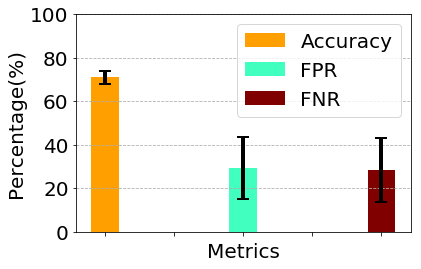

In [86]:
plot_results()